In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import scipy.io
import biosppy
import peakutils
%matplotlib notebook

#### This step is to extract raw signal into structured data (features,label)

## Load Dataset

<IPython.core.display.Javascript object>


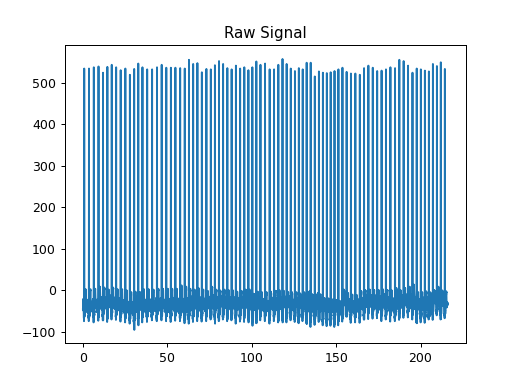

Text(0.5, 1.0, 'Raw Signal')

In [2]:
plt.figure()
#(AF)SVA812m.mat
#(NSR)ST309m.mat
#(PVC)SVA803m.mat

dataset = scipy.io.loadmat('Raw_dataset\\(NSR)ST309m.mat')
raw_signal = dataset['val'][0]
signal_len = len(raw_signal)
fs = 100
t = np.arange(0,signal_len)/fs
plt.plot(t,raw_signal)
plt.title('Raw Signal')

In [3]:
#detrend
detrend_signal = scipy.signal.detrend(raw_signal, axis=-1, type='linear', bp=0)

## Signal Processing

<IPython.core.display.Javascript object>


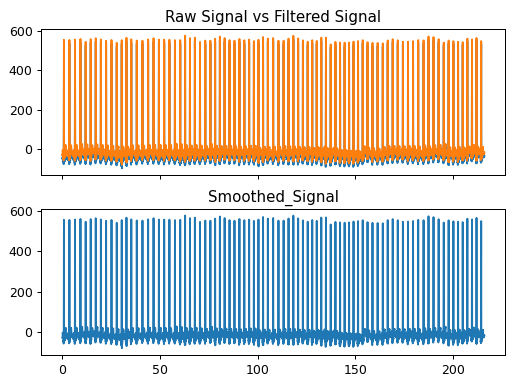

In [4]:
cutoff = 30 # frekuensi cutoff
nyq = 0.5 *fs
wn = cutoff/(nyq)

b, a = signal.butter(4,wn,btype='low', analog=False)
filtered_signal = signal.filtfilt(b,a,detrend_signal)

smoothed_signal = signal.cspline1d(filtered_signal,lamb=0.3)

fig, ax = plt.subplots(2, sharex = True)
ax[0].plot(t,raw_signal)
ax[0].plot(t,filtered_signal)

ax[0].set_title('Raw Signal vs Filtered Signal')

ax[1].plot(t,smoothed_signal)
ax[1].set_title('Smoothed_Signal')


plt.tight_layout()

##  Response Frequency

In [5]:
print(a)
print(b)

[1.         0.7820952  0.67997853 0.1826757  0.03011888]
[0.16717927 0.66871707 1.00307561 0.66871707 0.16717927]


<IPython.core.display.Javascript object>


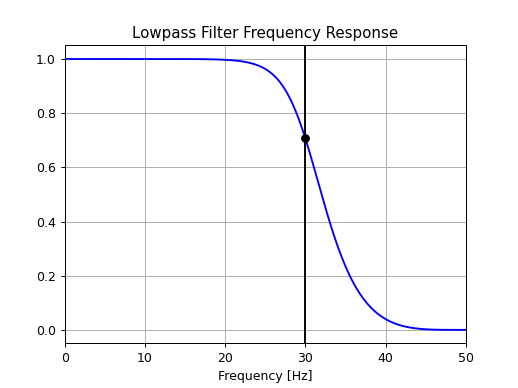

In [6]:
plt.figure()
w, h = signal.freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

##  Deteksi R-peak

##  SSF Algorithm

<IPython.core.display.Javascript object>


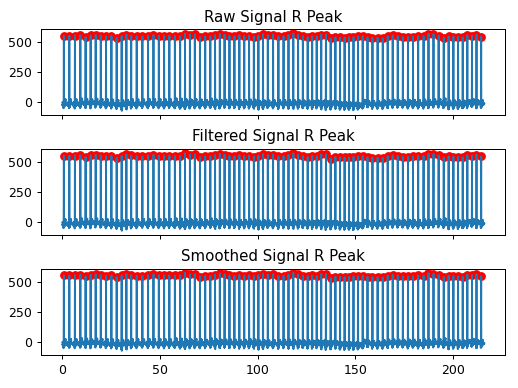

In [7]:
multiplier = 3
tres = 2000

#rpeak
fig, ax = plt.subplots(3, sharex = True, sharey = True)
raw_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=detrend_signal, sampling_rate=fs, threshold=tres, before=0.03, after=0.01)
raw_rpeak = raw_rpeak['rpeaks']/fs
r_index = []
for i in raw_rpeak:
    r_index.append(np.where(t == i))
    
if r_index == []:
    ax[0].plot(t,detrend_signal)
else:
    r_index = np.array(r_index)
    ax[0].plot(t,detrend_signal)
    ax[0].scatter(t[r_index],detrend_signal[r_index],c='r')
    ax[0].set_title('Raw Signal R Peak')


fil_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=filtered_signal, sampling_rate=fs, threshold=tres, before=0.03, after=0.01)
fil_rpeak = fil_rpeak['rpeaks']/fs
r_index2 = []
for j in fil_rpeak:
    r_index2.append(np.where(t == j))
if r_index2 == []:
    ax[1].plot(t,filtered_signal)
else:
    r_index2 = np.array(r_index2)
    ax[1].plot(t,filtered_signal)
    ax[1].scatter(t[r_index2],filtered_signal[r_index2],c='r')
    ax[1].set_title('Filtered Signal R Peak')


sm_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=smoothed_signal, sampling_rate=fs, threshold=tres, before=0.03, after=0.01)
sm_rpeak = sm_rpeak['rpeaks']/fs
r_index3 = []
for k in sm_rpeak:
    r_index3.append(np.where(t == k))
if r_index3 == []:
    ax[2].plot(t, smoothed_signal)
else:
    r_index3 = np.array(r_index3)
    ax[2].plot(t, smoothed_signal)
    ax[2].scatter(t[r_index3],smoothed_signal[r_index3],c='r')
    ax[2].set_title('Smoothed Signal R Peak')

plt.tight_layout()

<IPython.core.display.Javascript object>


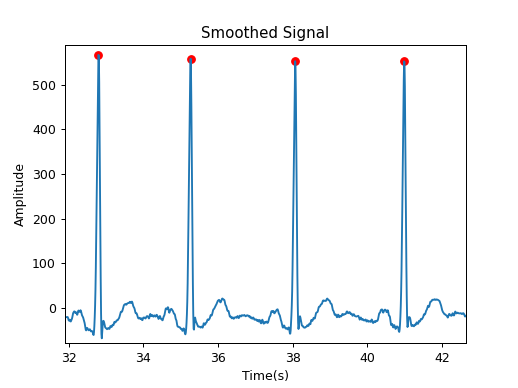

In [8]:
plt.figure()
tres = 3 * max(smoothed_signal)
sm_rpeak = biosppy.signals.ecg.ssf_segmenter(signal=smoothed_signal, sampling_rate=fs, threshold=tres, before=0.03, after=0.01)
sm_rpeak = sm_rpeak['rpeaks']/fs
r_index3 = []
for k in sm_rpeak:
    r_index3.append(np.where(t == k))
if r_index3 == []:
    plt.plot(t, smoothed_signal)
else:
    r_index3 = np.array(r_index3)
    r_index3 = r_index3.reshape(len(r_index3))
    plt.plot(t, smoothed_signal)
    plt.scatter(t[r_index3],smoothed_signal[r_index3],c='r')
    plt.title('Smoothed Signal')
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')

In [9]:
len(sm_rpeak)

85

In [23]:
RR_interval = np.diff(sm_rpeak)
RR_interval

array([1.46, 1.53, 0.84, 2.04, 1.44, 0.75, 2.08, 1.47, 0.67, 2.06, 1.37,
       1.39, 1.38, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.47, 1.48, 1.49, 1.5 ,
       1.45, 1.49, 1.46, 1.5 , 1.45, 1.5 , 1.43, 1.47, 1.44, 1.45, 1.46,
       1.48, 1.45, 1.45, 1.42, 1.46, 1.43, 1.45, 1.44, 1.46, 1.47, 1.47,
       1.44, 1.45, 1.41, 1.45, 1.44, 1.46, 1.42, 1.47])

## Feature Extraction

I input all of these features to excel and label them manually (extracted_data.xlsx)

In [24]:
#  Heart rate (beat per minute) 60s / RR_interval
heart_rate = 60/np.mean(RR_interval)
heart_rate

41.522491349480966

In [25]:
#  Standar deviasi dari RR interval yang sudah ternormalisasi
SDNN = np.std(RR_interval)
SDNN

0.22503418543720116

In [26]:
#  Persentase dari selisih RR interval yang lebih dari 50ms (0.05s).
NN50 = np.sum(np.abs(np.diff(RR_interval))> 0.05)
pNN50 = (NN50/len(RR_interval)) * 100
pNN50

21.153846153846153

In [28]:
RMSSD = (np.mean(np.diff(RR_interval) ** 2)) ** 0.5
RMSSD

0.3956255904806176

##  Heart Rate Stairs Plot

In [19]:
raw_hr = 60/RR_interval

In [20]:
rawhr_x= np.arange(0,len(raw_hr))

<IPython.core.display.Javascript object>


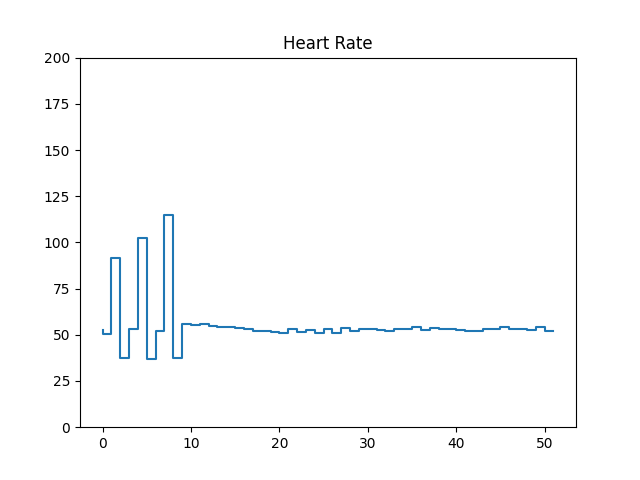

Text(0.5, 1.0, 'Heart Rate')

In [21]:
plt.figure()
plt.step(rawhr_x,raw_hr)
plt.ylim(0,200)
plt.title('Heart Rate')

## poincare plot

<IPython.core.display.Javascript object>


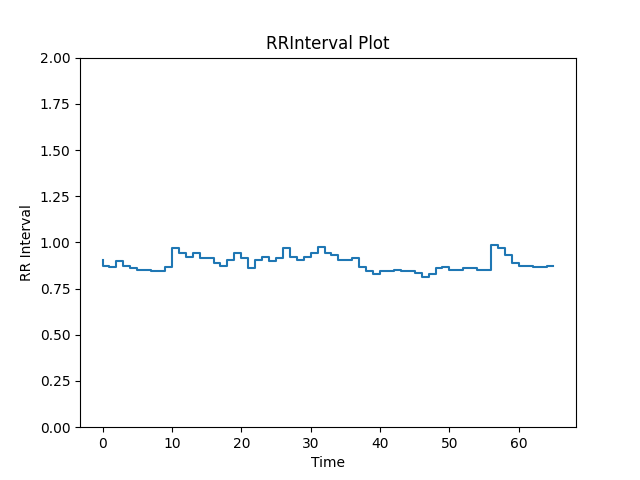

(0.0, 2.0)

In [41]:
plt.figure()
time_test = np.arange(0,len(RR_interval))
plt.step(time_test,RR_interval)
plt.title('RRInterval Plot')
plt.xlabel('Time')
plt.ylabel('RR Interval')
plt.ylim(0,2)

In [42]:
RR_interval

array([0.90625  , 0.875    , 0.8671875, 0.8984375, 0.875    , 0.859375 ,
       0.8515625, 0.8515625, 0.84375  , 0.84375  , 0.8671875, 0.96875  ,
       0.9453125, 0.921875 , 0.9453125, 0.9140625, 0.9140625, 0.890625 ,
       0.875    , 0.90625  , 0.9453125, 0.9140625, 0.859375 , 0.90625  ,
       0.921875 , 0.8984375, 0.9140625, 0.96875  , 0.921875 , 0.90625  ,
       0.921875 , 0.9453125, 0.9765625, 0.9453125, 0.9296875, 0.90625  ,
       0.90625  , 0.9140625, 0.8671875, 0.84375  , 0.828125 , 0.84375  ,
       0.84375  , 0.8515625, 0.84375  , 0.84375  , 0.8359375, 0.8125   ,
       0.828125 , 0.859375 , 0.8671875, 0.8515625, 0.8515625, 0.859375 ,
       0.859375 , 0.8515625, 0.8515625, 0.984375 , 0.96875  , 0.9296875,
       0.890625 , 0.875    , 0.875    , 0.8671875, 0.8671875, 0.875    ])

In [24]:
rr_len = len(RR_interval)
rr_len

138

In [25]:
r1 = RR_interval[1:rr_len]
r1

array([0.55, 0.57, 0.6 , 0.66, 0.6 , 0.6 , 0.59, 0.41, 0.8 , 0.43, 0.74,
       0.53, 0.57, 0.58, 0.48, 0.68, 0.53, 0.54, 0.54, 0.53, 0.54, 0.56,
       0.55, 0.54, 0.56, 0.59, 0.47, 0.64, 0.55, 0.59, 0.55, 0.56, 0.58,
       0.55, 0.55, 0.59, 0.58, 0.42, 0.66, 0.57, 0.56, 0.54, 0.55, 0.58,
       0.58, 0.48, 0.61, 0.57, 0.61, 0.57, 0.53, 0.57, 0.56, 0.56, 0.41,
       0.79, 0.56, 0.55, 0.4 , 0.15, 0.55, 0.55, 0.59, 0.56, 0.39, 0.15,
       0.56, 0.62, 0.58, 0.46, 0.66, 0.55, 0.55, 0.58, 0.61, 0.62, 0.44,
       0.64, 0.55, 0.55, 0.56, 0.59, 0.54, 0.55, 0.6 , 0.61, 0.41, 0.75,
       0.1 , 0.39, 0.06, 0.8 , 0.53, 0.56, 0.53, 0.53, 0.56, 0.59, 0.55,
       0.54, 0.58, 0.57, 0.55, 0.4 , 0.73, 0.55, 0.56, 0.59, 0.55, 0.54,
       0.6 , 0.55, 0.54, 0.61, 0.61, 0.41, 0.7 , 0.56, 0.61, 0.59, 0.55,
       0.55, 0.55, 0.55, 0.56, 0.59, 0.56, 0.54, 0.61, 0.57, 0.54, 0.58,
       0.65, 0.59, 0.56, 0.86, 0.55])

In [26]:
r2 = RR_interval[0:rr_len-1]
r2

array([0.6 , 0.55, 0.57, 0.6 , 0.66, 0.6 , 0.6 , 0.59, 0.41, 0.8 , 0.43,
       0.74, 0.53, 0.57, 0.58, 0.48, 0.68, 0.53, 0.54, 0.54, 0.53, 0.54,
       0.56, 0.55, 0.54, 0.56, 0.59, 0.47, 0.64, 0.55, 0.59, 0.55, 0.56,
       0.58, 0.55, 0.55, 0.59, 0.58, 0.42, 0.66, 0.57, 0.56, 0.54, 0.55,
       0.58, 0.58, 0.48, 0.61, 0.57, 0.61, 0.57, 0.53, 0.57, 0.56, 0.56,
       0.41, 0.79, 0.56, 0.55, 0.4 , 0.15, 0.55, 0.55, 0.59, 0.56, 0.39,
       0.15, 0.56, 0.62, 0.58, 0.46, 0.66, 0.55, 0.55, 0.58, 0.61, 0.62,
       0.44, 0.64, 0.55, 0.55, 0.56, 0.59, 0.54, 0.55, 0.6 , 0.61, 0.41,
       0.75, 0.1 , 0.39, 0.06, 0.8 , 0.53, 0.56, 0.53, 0.53, 0.56, 0.59,
       0.55, 0.54, 0.58, 0.57, 0.55, 0.4 , 0.73, 0.55, 0.56, 0.59, 0.55,
       0.54, 0.6 , 0.55, 0.54, 0.61, 0.61, 0.41, 0.7 , 0.56, 0.61, 0.59,
       0.55, 0.55, 0.55, 0.55, 0.56, 0.59, 0.56, 0.54, 0.61, 0.57, 0.54,
       0.58, 0.65, 0.59, 0.56, 0.86])

<IPython.core.display.Javascript object>


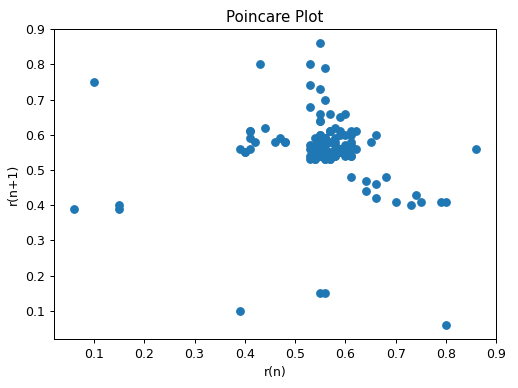

In [28]:
plt.figure()
plt.scatter(r1,r2)
plt.title('Poincare Plot')
plt.xlabel('r(n)')
plt.ylabel('r(n+1)')
plt.tight_layout()